# Subgroup Robustness Grows on Trees (Sample Complexity - Adult)
In this notebook, we (empirically) investigate the sample complexity needed for various model classes (including the
tree-based model classes in *Subgroup Robustness Grows on Trees*) to compete with some benchmark hypotheses classes
uniformly on all groups for the Adult dataset.

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pickle

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

## Datasets Overview
We'll run experiments on four datasets typically used in the fairness and robustness literature:

1. ACS Income (*large*). $n = 499,350$ examples, $20$ features, sensitive groups: *Race* and *Sex*.
2. ACS Employment (*large*). $n = 376,035$ examples, $17$ features, sensitive groups: *Race* and *Sex*. 
3. Adult (*medium*) $n = 48,845$ examples, $14$ features, sensitive groups: *Race* and *Sex*.
4. Communities and Crime (*small*) $n = 1,994$ examples, $113$ features, sensitive groups: *Income Level* and *Race.*

We also plan to do experiments with a fifth synthetic dataset that has overlapping group structure.

# Adult Dataset (Overlapping Groups)
The Adult Dataset is a benchmark derived from 1994 US Census data. The task is to predict whether an individual's income
exceeds $50,000 (binary classification). Sensitive attributes are *Race* and *Sex*.

- *Race:* $\{\text{White}, \text{Asian-Pac-Islander}, \text{Amer-Indian-Eskimo}, \text{Other}, \text{Black} \}$
- *Sex:* $\{\text{Male}, \text{Female}\}$

The standard in the literature has been to simplify the groups for *Race* to $\text{White}$ and $\text{NotWhite}$.

## Preprocess and Clean Adult
The Adult dataset is a binary classification task with *categorical* and *numerical* features. We binarize the categorical
features with `OneHotEncoder` and normalize the numerical features with `MinMaxScaler`. We also drop all the rows with missing
features, leaving us with $n = 45,222$ examples total.

In [194]:
# Adult Dataset
adult_names = ["age", "workclass", "fnlwgt", "education", "education-num",
                "marital-status", "occupation", "relationship", "race", "sex",
                "capital-gain", "capital-loss", "hours-per-week", "native-country", 
                "income"]
adult_data = pd.read_csv("./datasets/adult/adult.data", header=None, names=adult_names, na_values=' ?')
adult_data = adult_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
adult_test = pd.read_csv("./datasets/adult/adult.test", header=None, names=adult_names, na_values=' ?')
adult_test = adult_test.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
dfs = [adult_data, adult_test]
adult_df = pd.concat(dfs)
adult_df = adult_df.dropna()
adult_df = adult_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
print("Adult Shape: {}".format(adult_df.shape))

# last column in adult has some textual discrepancy
adult_df = adult_df.replace(">50K.", ">50K")
adult_df = adult_df.replace("<=50K.", "<=50K")

# Split into X and y
X, y = adult_df.drop("income", axis=1), adult_df["income"]

# Select categorical and numerical features
cat_idx = X.select_dtypes(include=["object", "bool"]).columns
num_idx = X.select_dtypes(include=['int64', 'float64']).columns
steps = [('cat', OneHotEncoder(handle_unknown='ignore'), cat_idx), ('num', MinMaxScaler(), num_idx)]
col_transf = ColumnTransformer(steps)

# label encoder to target variable so we have classes 0 and 1
assert(len(np.unique(y)) == 2)
y = LabelEncoder().fit_transform(y)
print("% examples >=50k (y=1): {}".format(100 * len(np.where(y == 1)[0])/len(y)))
print("% examples <50k (y=0): {}".format(100 * len(np.where(y == 0)[0])/len(y)))

Adult Shape: (45222, 15)
% examples >=50k (y=1): 24.78439697492371
% examples <50k (y=0): 75.21560302507629


Traditionally, there are $|\mathcal{G}| = 4$ groups in Adult: *(White, Male), (NotWhite, Male), (White, Female),* and *(NotWhite, Female)*.

In this notebook, we will instead do the following group structure for Adult:
- Overlapping groups (make *White* and *NotWhite* their own groups, make *Male* and *Female* their own groups).


In [195]:
def adult_gp_indices(df, race_val, sex_val):
    if race_val == "NotWhite":
        return np.where((df['race'] != 'White') & (df['sex'] == sex_val))
    else:
        return np.where((df['race'] == race_val) & (df['sex'] == sex_val))

group_names = ["ALL", "W,M", "W,F", "nW,M", "nW,F", "W", "nW", "M", "F"]
group_memberships = []
group_memberships.append([True] * y.shape[0])
race_gps_coarse = ["White", "NotWhite"]
sex_gps = ["Male", "Female"]

# Traditional disjoint groups
for race in race_gps_coarse:
    for sex in sex_gps:
        indices = adult_gp_indices(X, race, sex)[0]
        membership = np.zeros(y.shape[0], dtype=bool)
        membership[indices] = True
        group_memberships.append(membership)

# Add 4 overlapping groups
w_indices = np.where(X['race'] == 'White')
w_membership = np.zeros(y.shape[0], dtype=bool)
w_membership[w_indices] = True
group_memberships.append(w_membership)

nw_indices = np.where(X['race'] != 'White')
nw_membership = np.zeros(y.shape[0], dtype=bool)
nw_membership[nw_indices] = True
group_memberships.append(nw_membership)

m_indices = np.where(X['sex'] == 'Male')
m_membership = np.zeros(y.shape[0], dtype=bool)
m_membership[m_indices] = True
group_memberships.append(m_membership)

f_indices = np.where(X['sex'] == 'Female')
f_membership = np.zeros(y.shape[0], dtype=bool)
f_membership[f_indices] = True
group_memberships.append(f_membership)

num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 9


In [196]:
# Fit the ColumnTransformer to X
X_transf = col_transf.fit_transform(X)
print("Column-transformed X has shape: {}".format(X_transf.shape))

# Train-test split
splits = train_test_split(*tuple([X, y] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

Column-transformed X has shape: (45222, 104)


In [197]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

# TODO: fix column alignment issue :(
print('Group\t\t\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t\t\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group			train	test
0 (ALL)			36177	9045
1 (W,M)			21603	5417
2 (W,F)			9520	2363
3 (nW,M)			2815	692
4 (nW,F)			2239	573
5 (W)			31123	7780
6 (nW)			5054	1265
7 (M)			24418	6109
8 (F)			11759	2936


In [198]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.24378109452736318
P(Y=1 | group 1) = 0.31733431788812994
P(Y=1 | group 2) = 0.12018620397799408
P(Y=1 | group 3) = 0.22687861271676302
P(Y=1 | group 4) = 0.07853403141361257
P(Y=1 | group 5) = 0.25745501285347044
P(Y=1 | group 6) = 0.15968379446640316
P(Y=1 | group 7) = 0.307087903093796
P(Y=1 | group 8) = 0.11205722070844687


## Fit Benchmark Class (Logistic Regression)
First, we fit a simple benchmark class $\mathcal{H}$ that we aim to compete against. In this case, we will be competing
against Logistic Regression. For different competing classes $\mathcal{F}$, we will aim find the minimum number of samples 
that allows us to achieve
$$
\min_{f \in \mathcal{F}} \mathcal{R}(f \mid g) \leq \min_{h \in \mathcal{H}} \mathcal{R}(h \mid g) + \epsilon_g \quad \text{ for all } g \in \mathcal{G},
$$
where $\mathcal{H}$ is the class of Logistic Regression classifiers, and $\epsilon_g = 0$ for all $g \in \mathcal{G}$.
Note that this means we are training a different Logistic Regression classifier for each group (but only a *single* model
$f \in \mathcal{F}$ to compete against the Logistic Regression classifiers).

In [201]:
LOAD_LOGREG = True
pickle_dir = './pickled_results/'

In [202]:
# Cross-validate to find "best" baseline Logistic Regression for our train-test split
from sklearn.linear_model import LogisticRegressionCV

logreg_pkl_name = "scomp_target.pkl"
logreg_pkl_path = os.path.join(pickle_dir, logreg_pkl_name)
def std_err(err, n_g):
    return np.sqrt(2. * err * (1.0 - err) / n_g)

if LOAD_LOGREG:
    with open(logreg_pkl_path, 'rb') as handle:
        target_errs, target_yhats, target_std_errs = pickle.load(handle)
else:
    target_errs = {}
    target_yhats = {}
    target_std_errs = {}
    for g in range(num_groups):
        logreg = LogisticRegressionCV(cv=5, random_state=0, max_iter=500, n_jobs=5).fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        target_yhats[g] = logreg.predict(col_transf.transform(X_test))
        target_errs[g] = np.mean(y_test[group_test[g]] != target_yhats[g][group_test[g]])
        target_std_errs[g] = std_err(target_errs[g], num_group_train[g])
    
    # store logreg data
    with open(logreg_pkl_path, 'wb') as handle:
        pickle.dump((target_errs, target_yhats, target_std_errs), handle, protocol=pickle.HIGHEST_PROTOCOL)
        LOAD_LOGREG = True

In [203]:
for g in range(num_groups):
    print("R( h | g=({0})) = {1} (+/- {2})".format(group_names[g], target_errs[g], target_std_errs[g]))

R( h | g=(ALL)) = 0.1490326147042565 (+/- 0.0026478650123075887)
R( h | g=(W,M)) = 0.19198818534244047 (+/- 0.0037896933737924378)
R( h | g=(W,F)) = 0.07829030892932713 (+/- 0.0038935665655317102)
R( h | g=(nW,M)) = 0.14017341040462428 (+/- 0.009253670978928312)
R( h | g=(nW,F)) = 0.059336823734729496 (+/- 0.007061015587007798)
R( h | g=(W)) = 0.15694087403598972 (+/- 0.002915891244875172)
R( h | g=(nW)) = 0.10039525691699605 (+/- 0.005978329461662596)
R( h | g=(M)) = 0.1869373056146669 (+/- 0.003528336195662721)
R( h | g=(F)) = 0.0739100817438692 (+/- 0.003411993711938966)


## Fit Models to Sufficient Error
Now, we fit our competing models with increasing sample sizes of training data until they are competitive with $\mathcal{H}$,
the Logistic Regression classifiers, within the standard error of:
$$
\epsilon_g := \sqrt{\frac{2 \times \mathcal{R}(h \mid g) (1 - \mathcal{R}(h \mid g))}{n_g}},
$$
where $n_g$ is the number of examples in group $g$ used to train the Logistic Regression classifier, $h$. That is, we 
aim to find the minimum number of examples $N$, such that training $f$ on $N$ examples with standard ERM yields:
$$
\mathcal{R}(f \mid g) \leq \mathcal{R}(h \mid g) + \epsilon_g \quad \text{ for all } g \in \mathcal{G}.
$$
The $\mathcal{F}$ "competitor" model classes we will evaluate against are:
1. (Single) decision tree.
2. Random forests.
3. Gradient-boosted trees.
4. SVM (with RBF or polynomial kernel).
5. Logistic Regression Prepend.
6. Multilayer Perceptron (with varying hidden layer sizes).

In [204]:
# Utilities for fitting  and evaluating models
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from joblib import Parallel, delayed

'''
Function for training a model ERM on some KFold splits and then evaluating on
each group for each of the splits.
'''
def split_and_eval(X, y, model, transformer, group_memberships, num_groups, train_size):
    splits = train_test_split(*tuple([X, y] + group_memberships), train_size=train_size)
    X_train = splits[0]
    X_test = splits[1]
    y_train = splits[2]
    y_test = splits[3]

    group_train = splits[4::2]
    group_test = splits[5::2]
    model.fit(transformer.transform(X_train), y_train)

    # Evaluate on all groups
    yhats = {}
    test_errs = {}
    for g in range(num_groups):
        yhats[g] = model.predict(transformer.transform(X_test))
        test_errs[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])        
    
    return yhats, test_errs

def paralell_split_eval(X, y, model, transformer, group_memberships, num_groups, train_size, n_splits, n_jobs=-1):
    parallel = Parallel(n_jobs=n_jobs)
    results = parallel(
        delayed(split_and_eval)(X, y, model, transformer, group_memberships, 
                                num_groups, train_size
        )
        for split in range(n_splits)
    )

    mean_test_errs = {}
    std_errs = {}
    for g in range(num_groups):
        test_errs_g = [test_errs[g] for _, test_errs in results]
        mean_test_errs[g] = np.mean(test_errs_g)
        std_errs[g] = np.sqrt( np.var(test_errs_g) ) / n_splits

    return mean_test_errs, std_errs

In [205]:
# PREPEND CODE
def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def split_and_eval_prepend(X, y, model, transformer, group_memberships, num_groups, train_size):
    splits = train_test_split(*tuple([X, y] + group_memberships), train_size=train_size)
    X_train = splits[0]
    X_test = splits[1]
    y_train = splits[2]
    y_test = splits[3]

    group_train = splits[4::2]
    group_test = splits[5::2]

    # need to train models first before prepend
    models = {}
    for g in range(num_groups):
        models[g] = model()
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])


    f, test_errs = prepend(models, X_train, group_train, X_test, group_test,
                            y_train, y_test, col_transf, num_groups)

    # Evaluate on all groups
    yhats = {}
    test_errs = {}
    for g in range(num_groups):
        yhats[g] = model.predict(transformer.transform(X_test))
        test_errs[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])        
    
    return yhats, test_errs

def paralell_split_eval_prepend(X, y, model, transformer, group_memberships, num_groups, train_size, n_splits, n_jobs=-1):
    parallel = Parallel(n_jobs=n_jobs)
    results = parallel(
        delayed(split_and_eval)(X, y, model, transformer, group_memberships, 
                                num_groups, train_size
        )
        for split in range(n_splits)
    )

    mean_test_errs = {}
    std_errs = {}
    for g in range(num_groups):
        test_errs_g = [test_errs[g] for _, test_errs in results]
        mean_test_errs[g] = np.mean(test_errs_g)
        std_errs[g] = np.sqrt( np.var(test_errs_g) ) / n_splits

    return mean_test_errs, std_errs

In [218]:
# training set sizes will be pulled linearly from the range [100, 0.8 * training_size]
train_sizes = list(np.linspace(100, len(X) * 0.8, num=20, dtype=int))
print("Range of training set sizes: {}".format(train_sizes))

# flags for pickling
LOAD_DT = True
LOAD_RF = True
LOAD_GB = True
LOAD_SVM = True
LOAD_PREPEND = False
LOAD_MLP = False

Range of training set sizes: [100, 1998, 3897, 5796, 7695, 9594, 11492, 13391, 15290, 17189, 19088, 20987, 22885, 24784, 26683, 28582, 30481, 32379, 34278, 36177]


In [222]:
# Fit Decision Trees (default parameters)
dt_test_errs = list()
dt_std_errs = list()
dt_pkl_name = 'scomp_dt.pkl'
dt_pkl_path = os.path.join(pickle_dir, dt_pkl_name)

if LOAD_DT:
    with open(dt_pkl_path, 'rb') as handle:
        dt_test_errs, dt_std_errs = pickle.load(handle)
else:
    for train_size in train_sizes:
        model = DecisionTreeClassifier()
        mean_test_errs, std_errs = paralell_split_eval(X, y, model, col_transf, group_memberships, num_groups, train_size=train_size, n_splits=8)
        print("Decision Tree ERM test error (n={0} training examples): {1} (+/- {2})".format(train_size, mean_test_errs[0], std_errs[0]))
        dt_test_errs.append(mean_test_errs)
        dt_std_errs.append(std_errs)

    # store decision tree data
    with open(dt_pkl_path, 'wb') as handle:
        pickle.dump((dt_test_errs, dt_std_errs), handle, protocol=pickle.HIGHEST_PROTOCOL)
        LOAD_DT = True

In [211]:
# Fit Random Forests (default parameters)
rf_test_errs = list()
rf_std_errs = list()
rf_pkl_name = 'scomp_rf.pkl'
rf_pkl_path = os.path.join(pickle_dir, rf_pkl_name)

if LOAD_RF:
    with open(rf_pkl_path, 'rb') as handle:
        rf_test_errs, rf_std_errs = pickle.load(handle)
else:
    for train_size in train_sizes:
        model = RandomForestClassifier()
        mean_test_errs, std_errs = paralell_split_eval(X, y, model, col_transf, group_memberships, num_groups, train_size=train_size, n_splits=8)
        print("RF ERM test error (n={0} training examples): {1} (+/- {2})".format(train_size, mean_test_errs[0], std_errs[0]))
        rf_test_errs.append(mean_test_errs)
        rf_std_errs.append(std_errs)

    # store random forest data
    with open(rf_pkl_path, 'wb') as handle:
        pickle.dump((rf_test_errs, rf_std_errs), handle, protocol=pickle.HIGHEST_PROTOCOL)
        LOAD_RF = True

RF ERM test error (n=100 training examples): 0.19673053056158857 (+/- 0.0014014756118431175)
RF ERM test error (n=1998 training examples): 0.16153063113085322 (+/- 0.0003836472935037426)
RF ERM test error (n=3897 training examples): 0.1558832425892317 (+/- 0.00011743716374821264)
RF ERM test error (n=5796 training examples): 0.15434294627910516 (+/- 0.00026364942121007953)
RF ERM test error (n=7695 training examples): 0.15304314227089827 (+/- 0.0001605751689922862)
RF ERM test error (n=9594 training examples): 0.1519556247894914 (+/- 0.0002050916642884529)
RF ERM test error (n=11492 training examples): 0.15222724577527424 (+/- 0.00016578401331637812)
RF ERM test error (n=13391 training examples): 0.15158964531431623 (+/- 0.0001430490454813807)
RF ERM test error (n=15290 training examples): 0.14986886943739142 (+/- 0.0001524207937128329)
RF ERM test error (n=17189 training examples): 0.15133503371027004 (+/- 0.0001457383037816652)
RF ERM test error (n=19088 training examples): 0.1508332

In [212]:
# Fit Gradient-Boosted Trees (default parameters)
gb_test_errs = list()
gb_std_errs = list()
gb_pkl_name = 'scomp_gb.pkl'
gb_pkl_path = os.path.join(pickle_dir, gb_pkl_name)

if LOAD_GB:
    with open(gb_pkl_path, 'rb') as handle:
        gb_test_errs, gb_std_errs = pickle.load(handle)
else:
    for train_size in train_sizes:
        model = GradientBoostingClassifier()
        mean_test_errs, std_errs = paralell_split_eval(X, y, model, col_transf, group_memberships, num_groups, train_size=train_size, n_splits=8)
        print("GB ERM test error (n={0} training examples): {1} (+/- {2})".format(train_size, mean_test_errs[0], std_errs[0]))
        gb_test_errs.append(mean_test_errs)
        gb_std_errs.append(std_errs)

    # store gradient-boosted trees data
    with open(gb_pkl_path, 'wb') as handle:
        pickle.dump((gb_test_errs, gb_std_errs), handle, protocol=pickle.HIGHEST_PROTOCOL)
        LOAD_GB = True

In [213]:
# Find optimal SVM hyperparameters first on most of the data
SVM_CV = False

if SVM_CV:
    params = {'kernel': ['rbf', 'poly'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}
    svc = SVC()
    model = GridSearchCV(svc, params, n_jobs=-1, verbose=3)
    model.fit(col_transf.transform(X), y)

    svm_model_pkl_name = 'scomp_svm_cv.pkl'
    svm_model_pkl_path = os.path.join(pickle_dir, svm_model_pkl_name)
    with open(svm_model_pkl_path, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [215]:
# Fit SVM (tune C and kernel hyperparameters)
# SVM takes long to train...make the number of train sizes a bit smaller
svm_train_sizes = list(np.linspace(100, len(X) * 0.8, num=10, dtype=int))

svm_test_errs = list()
svm_std_errs = list()
svm_pkl_name = 'scomp_svm.pkl'
svm_pkl_path = os.path.join(pickle_dir, svm_pkl_name)

if LOAD_SVM:
    with open(svm_pkl_path, 'rb') as handle:
        svm_test_errs, svm_std_errs = pickle.load(handle)
else:
    for train_size in svm_train_sizes:
        model = SVC(C=10, kernel='rbf')
        mean_test_errs, std_errs = paralell_split_eval(X, y, model, col_transf, group_memberships, num_groups, train_size=train_size, n_splits=3)
        print("SVM ERM test error (n={0} training examples): {1} (+/- {2})".format(train_size, mean_test_errs[0], std_errs[0]))
        svm_test_errs.append(mean_test_errs)
        svm_std_errs.append(std_errs)

    # store svm data
    with open(svm_pkl_path, 'wb') as handle:
        pickle.dump((svm_test_errs, svm_std_errs), handle, protocol=pickle.HIGHEST_PROTOCOL)
        LOAD_SVM = True

## Plot Training Samples vs. Accuracy
We now plot the training samples vs. accuracy for each of the model classes, and compare it to Logistic Regression, our
"benchmark" hypothesis class.

### Plot 1: Number of Samples vs. Worst-group Accuracy
First, we plot the number of samples needed for each model class to beat the worst-group accuracy of the benchmark class,
Logistic Regression.

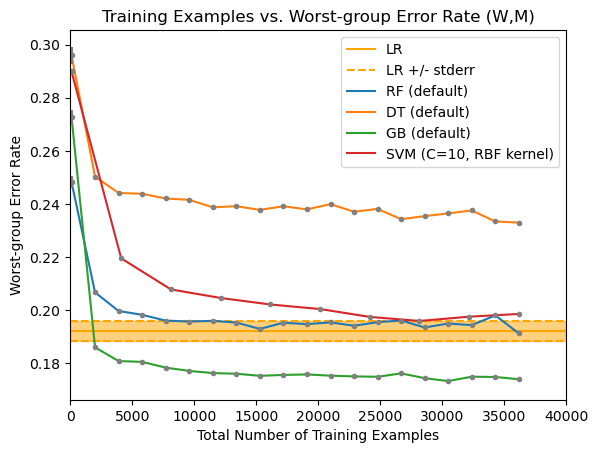

In [221]:
# Plot training set size vs. worst-group accuracy
fig, ax = plt.subplots()

# threshold for Logistic Regression
xlim = [0, 40000]
ax.fill_between(x=xlim, y1=target_errs[1] - target_std_errs[1], y2=target_errs[1] + target_std_errs[1], color='orange',  interpolate=True, alpha=.5)
ax.axhline(y=target_errs[1], color='orange', label="LR")
ax.axhline(y=target_errs[1] + target_std_errs[1], color='orange', linestyle='dashed', label="LR +/- stderr")
ax.axhline(y=target_errs[1] - target_std_errs[1], color='orange', linestyle='dashed')

# random forest
rf_worst_gp_errs = [test_errs[1] for test_errs in rf_test_errs]
rf_worst_gp_errbars = [std_errs[1] for std_errs in rf_std_errs]
ax.plot(train_sizes, rf_worst_gp_errs, label="RF (default)")
ax.errorbar(train_sizes, rf_worst_gp_errs, fmt='.', yerr=rf_worst_gp_errbars, color='grey')

# decision trees
dt_worst_gp_errs = [test_errs[1] for test_errs in dt_test_errs]
dt_worst_gp_errbars = [std_errs[1] for std_errs in dt_std_errs]
ax.plot(train_sizes, dt_worst_gp_errs, label="DT (default)")
ax.errorbar(train_sizes, dt_worst_gp_errs, fmt='.', yerr=dt_worst_gp_errbars, color='grey')

# gradient-boosted trees
gb_worst_gp_errs = [test_errs[1] for test_errs in gb_test_errs]
gb_worst_gp_errbars = [std_errs[1] for std_errs in gb_std_errs]
ax.plot(train_sizes, gb_worst_gp_errs, label="GB (default)")
ax.errorbar(train_sizes, gb_worst_gp_errs, fmt='.', yerr=gb_worst_gp_errbars, color='grey')

# SVM
svm_worst_gp_errs = [test_errs[1] for test_errs in svm_test_errs]
svm_worst_gp_errbars = [std_errs[1] for std_errs in svm_std_errs]
ax.plot(svm_train_sizes, svm_worst_gp_errs, label="SVM (C=10, RBF kernel)")
ax.errorbar(svm_train_sizes, svm_worst_gp_errs, fmt='.', yerr=svm_worst_gp_errbars, color='grey')

ax.set_xlim(xlim)
ax.set_title("Training Examples vs. Worst-group Error Rate (W,M)")
ax.set_xlabel('Total Number of Training Examples')
ax.set_ylabel('Worst-group Error Rate')
ax.legend()

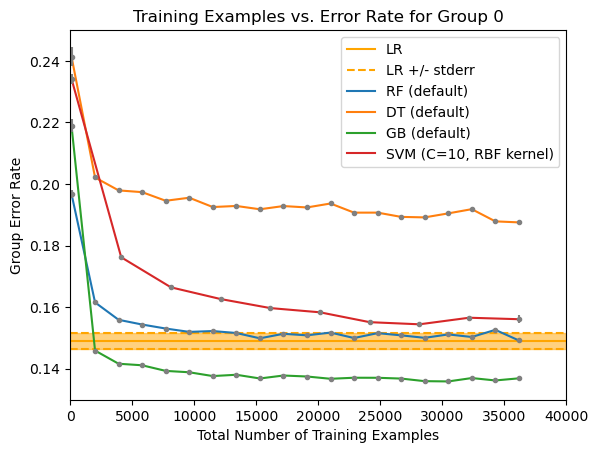

In [286]:
# Plot training set size vs. worst-group accuracy
fig, ax = plt.subplots()
g = 0

# threshold for Logistic Regression
xlim = [0, 40000]
ax.fill_between(x=xlim, y1=target_errs[g] - target_std_errs[g], y2=target_errs[g] + target_std_errs[g], color='orange',  interpolate=True, alpha=.5)
ax.axhline(y=target_errs[g], color='orange', label="LR")
ax.axhline(y=target_errs[g] + target_std_errs[g], color='orange', linestyle='dashed', label="LR +/- stderr")
ax.axhline(y=target_errs[g] - target_std_errs[g], color='orange', linestyle='dashed')

# random forest
rf_worst_gp_errs = [test_errs[g] for test_errs in rf_test_errs]
rf_worst_gp_errbars = [std_errs[g] for std_errs in rf_std_errs]
ax.plot(train_sizes, rf_worst_gp_errs, label="RF (default)")
ax.errorbar(train_sizes, rf_worst_gp_errs, fmt='.', yerr=rf_worst_gp_errbars, color='grey')

# decision trees
dt_worst_gp_errs = [test_errs[g] for test_errs in dt_test_errs]
dt_worst_gp_errbars = [std_errs[g] for std_errs in dt_std_errs]
ax.plot(train_sizes, dt_worst_gp_errs, label="DT (default)")
ax.errorbar(train_sizes, dt_worst_gp_errs, fmt='.', yerr=dt_worst_gp_errbars, color='grey')

# gradient-boosted trees
gb_worst_gp_errs = [test_errs[g] for test_errs in gb_test_errs]
gb_worst_gp_errbars = [std_errs[g] for std_errs in gb_std_errs]
ax.plot(train_sizes, gb_worst_gp_errs, label="GB (default)")
ax.errorbar(train_sizes, gb_worst_gp_errs, fmt='.', yerr=gb_worst_gp_errbars, color='grey')

# SVM
svm_worst_gp_errs = [test_errs[g] for test_errs in svm_test_errs]
svm_worst_gp_errbars = [std_errs[g] for std_errs in svm_std_errs]
ax.plot(svm_train_sizes, svm_worst_gp_errs, label="SVM (C=10, RBF kernel)")
ax.errorbar(svm_train_sizes, svm_worst_gp_errs, fmt='.', yerr=svm_worst_gp_errbars, color='grey')

ax.set_xlim(xlim)
ax.set_title("Training Examples vs. Error Rate for Group {}".format(g))
ax.set_xlabel('Total Number of Training Examples')
ax.set_ylabel('Group Error Rate')
ax.legend()

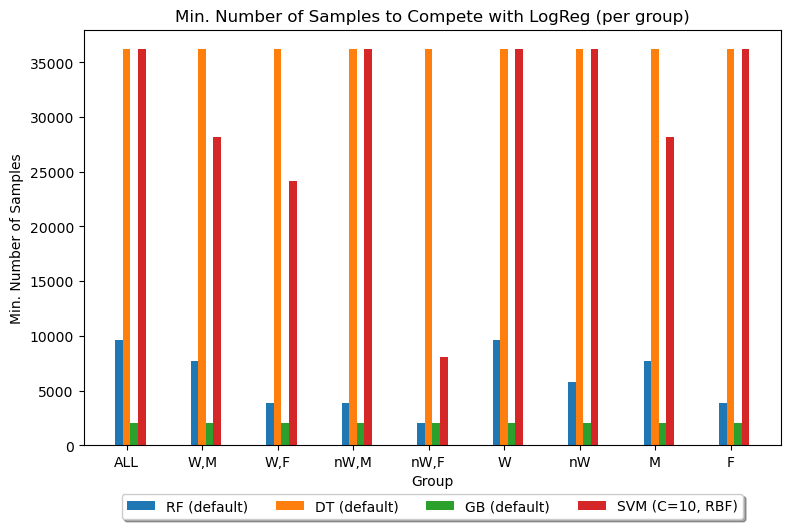

In [284]:
# Find the minimum number of examples to reach logreg + stderr for each group for each model class
def min_close_zero(errs, tol=1e-3):
    for i, err in enumerate(errs):
        if err < tol:
            return i, err
    return -1, 10

rf_min_samples = list()
dt_min_samples = list()
gb_min_samples = list()
svm_min_samples = list()
for g in range(num_groups):
    rf_gp_errs = [test_errs[g] - (target_errs[g] + target_std_errs[g]) for test_errs in rf_test_errs]
    dt_gp_errs = [test_errs[g] - (target_errs[g] + target_std_errs[g]) for test_errs in dt_test_errs]
    gb_gp_errs = [test_errs[g] - (target_errs[g] + target_std_errs[g]) for test_errs in gb_test_errs]
    svm_gp_errs = [test_errs[g] - (target_errs[g] + target_std_errs[g]) for test_errs in svm_test_errs]

    rf_idx, _ = min_close_zero(rf_gp_errs)
    dt_idx, _ = min_close_zero(dt_gp_errs)
    gb_idx, _ = min_close_zero(gb_gp_errs)
    svm_idx, _ = min_close_zero(svm_gp_errs)

    rf_min_samples.append(train_sizes[rf_idx])
    dt_min_samples.append(train_sizes[dt_idx])
    gb_min_samples.append(train_sizes[gb_idx])
    svm_min_samples.append(svm_train_sizes[svm_idx])

plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 1.0*bar_width, [rf_min_samples[g] for g in range(num_groups)], bar_width, label='RF (default)')
plot_rects2 = ax.bar(plot_x - 0*bar_width, [dt_min_samples[g] for g in range(num_groups)], bar_width, label='DT (default)')
plot_rects3 = ax.bar(plot_x + 1.0*bar_width, [gb_min_samples[g] for g in range(num_groups)], bar_width, label='GB (default)')
plot_rects4 = ax.bar(plot_x + 2.0*bar_width, [svm_min_samples[g] for g in range(num_groups)], bar_width, label='SVM (C=10, RBF)')

ax.set_ylabel('Min. Number of Samples')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Min. Number of Samples to Compete with LogReg (per group)")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)